In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset, get_dataset_split_names, DatasetDict
from tqdm import tqdm

sns.set_color_codes("colorblind")
sns.set_theme(style="darkgrid")
sns.set_context("talk")
tqdm.pandas()

/home/mchorse/miniconda3/envs/memorization/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Datasets

In [2]:
split_sample_size = None
label_title_padding = 10
study_pile = False
RECITATION_THRESHOLD = 2

In [3]:
memories_path = "usvsnsp/generation-semantic-filters"
intermediate_path = "usvsnsp/generation-semantic-intermediate-filters"
memories_dataset = DatasetDict()
splits = [split for split in get_dataset_split_names(memories_path) if "deduped" in split] + get_dataset_split_names(intermediate_path)
# drop splits with "pile" in the name
splits = [split for split in splits if "pile" not in split and "deduped" in split]
print(splits)

['memories_deduped_410m', 'memories_deduped_1.4b', 'memories_deduped_6.9b', 'memories_deduped_1b', 'memories_deduped_12b', 'memories_deduped_70m', 'memories_deduped_2.8b', 'memories_deduped_160m', 'memories_deduped_12b.43000', 'memories_deduped_12b.103000', 'memories_deduped_12b.83000', 'memories_deduped_12b.63000', 'memories_deduped_12b.123000', 'memories_deduped_12b.23000']


In [4]:
print("Loading datasets...")
print(f"Split sample size: {split_sample_size}")

for split in tqdm(splits):
    model = split.split("_")[-1]
    checkpoint = int(split.split(".")[-1]) if split.split(".")[-1][1].isnumeric() else "Final"
    formatted_split_name = split.replace("memories_", "").replace("deduped_", "deduped.")
    dataset_path = memories_path if checkpoint == "Final" else intermediate_path
    memories_dataset[formatted_split_name] = load_dataset(dataset_path, split=f"{split}[:{split_sample_size}]" if split_sample_size else split)

memories_dataset

Loading datasets...
Split sample size: None


100%|██████████| 14/14 [02:06<00:00,  9.05s/it]


DatasetDict({
    deduped.410m: Dataset({
        features: ['sequence_id', 'tokens', 'text', 'is_incrementing', 'is_repeating', 'sequence_duplicates', 'max_frequency', 'avg_frequency', 'min_frequency', 'median_frequency', 'p25_frequency', 'p75_frequency', 'frequencies', 'nl_scores', '0_8_snowclones', '0_9_snowclones', '0_8_templates', '0_9_templates', 'huffman_coding_length', 'memorization_score', 'generation_perplexity', 'prompt_perplexity', 'sequence_perplexity'],
        num_rows: 811040
    })
    deduped.1.4b: Dataset({
        features: ['sequence_id', 'tokens', 'text', 'is_incrementing', 'is_repeating', 'sequence_duplicates', 'max_frequency', 'avg_frequency', 'min_frequency', 'median_frequency', 'p25_frequency', 'p75_frequency', 'frequencies', 'nl_scores', '0_8_snowclones', '0_9_snowclones', '0_8_templates', '0_9_templates', 'huffman_coding_length', 'memorization_score', 'generation_perplexity', 'prompt_perplexity', 'sequence_perplexity'],
        num_rows: 1048097
    })
    d

In [5]:
split_to_param_count = {
    "70m": 70000000,
    "160m": 160000000,
    "410m": 410000000,
    "1b": 1000000000,
    "1.4b": 1400000000,
    "2.8b": 2800000000,
    "6.9b": 6900000000,
    "12b": 12000000000,
}

In [6]:
columns_to_drop = ["frequencies", "tokens"]
combined_dataframe = None
for split in tqdm(memories_dataset, desc="Loading Memories"):
    current_frame = memories_dataset[split].to_pandas()
    current_frame.drop(columns=columns_to_drop, inplace=True)
    checkpoint = int(split.split(".")[-1]) if split.split(".")[-1][1].isnumeric() and len(split.split(".")) != 2 else "Final"
    current_frame["Checkpoint"] = checkpoint
    model = split.split("deduped")[-1][1:] if checkpoint == "Final" else split.split(".")[-2]
    print(f"Model: {model} from {split}")
    current_frame["Model"] = model
    current_frame["Param Count"] = split_to_param_count[current_frame["Model"].iloc[0]]
    current_frame["Deduped"] = "deduped" in split
    current_frame["Memorized"] = True
    if combined_dataframe is None:
        combined_dataframe = current_frame
    else:
        combined_dataframe = pd.concat([combined_dataframe, current_frame])

combined_dataframe = combined_dataframe.sort_values("Param Count")
display(combined_dataframe.shape)
display(combined_dataframe.columns)
combined_dataframe.head()

Loading Memories:   7%|▋         | 1/14 [00:01<00:17,  1.35s/it]

Model: 410m from deduped.410m
Model: 1.4b from deduped.1.4b


Loading Memories:  14%|█▍        | 2/14 [00:03<00:21,  1.79s/it]

Model: 6.9b from deduped.6.9b


Loading Memories:  21%|██▏       | 3/14 [00:06<00:28,  2.58s/it]

Model: 1b from deduped.1b


Loading Memories:  29%|██▊       | 4/14 [00:09<00:25,  2.55s/it]

Model: 12b from deduped.12b


Loading Memories:  36%|███▌      | 5/14 [00:13<00:28,  3.15s/it]

Model: 70m from deduped.70m


Loading Memories:  43%|████▎     | 6/14 [00:15<00:20,  2.57s/it]

Model: 2.8b from deduped.2.8b


Loading Memories:  50%|█████     | 7/14 [00:18<00:19,  2.80s/it]

Model: 160m from deduped.160m


Loading Memories:  57%|█████▋    | 8/14 [00:20<00:15,  2.57s/it]

Model: 12b from deduped.12b.43000


Loading Memories:  64%|██████▍   | 9/14 [00:22<00:11,  2.34s/it]

Model: 12b from deduped.12b.103000


Loading Memories:  71%|███████▏  | 10/14 [00:25<00:10,  2.66s/it]

Model: 12b from deduped.12b.83000


Loading Memories:  79%|███████▊  | 11/14 [00:28<00:08,  2.78s/it]

Model: 12b from deduped.12b.63000


Loading Memories:  86%|████████▌ | 12/14 [00:31<00:05,  2.78s/it]

Model: 12b from deduped.12b.123000


Loading Memories:  93%|█████████▎| 13/14 [00:36<00:03,  3.44s/it]

Model: 12b from deduped.12b.23000


Loading Memories: 100%|██████████| 14/14 [00:38<00:00,  2.75s/it]


(13510427, 26)

Index(['sequence_id', 'text', 'is_incrementing', 'is_repeating',
       'sequence_duplicates', 'max_frequency', 'avg_frequency',
       'min_frequency', 'median_frequency', 'p25_frequency', 'p75_frequency',
       'nl_scores', '0_8_snowclones', '0_9_snowclones', '0_8_templates',
       '0_9_templates', 'huffman_coding_length', 'memorization_score',
       'generation_perplexity', 'prompt_perplexity', 'sequence_perplexity',
       'Checkpoint', 'Model', 'Param Count', 'Deduped', 'Memorized'],
      dtype='object')

,sequence_id,text,is_incrementing,is_repeating,sequence_duplicates,max_frequency,avg_frequency,min_frequency,median_frequency,p25_frequency,...,huffman_coding_length,memorization_score,generation_perplexity,prompt_perplexity,sequence_perplexity,Checkpoint,Model,Param Count,Deduped,Memorized
311694,76386464,\x35 |0\n<U0036> \x36 |0\n<U0037> \x37 |0\n<U...,True,False,86,11740996961,1.338496e+09,444483,328011365.0,68483657,...,4.137255,1.0,1.173395,3.283641,3.853008,Final,70m,70000000,True,True
274304,101528653,"0 (the ""License"");\n// you may not use this fi...",False,False,126590,11740996961,2.183443e+09,2535454,397855078.0,24463239,...,4.883721,1.0,1.014786,2.595823,2.634206,Final,70m,70000000,True,True
274303,101488489,permissions and limitations under the License...,False,False,12551,11740996961,2.955296e+09,605886,223388936.0,16400100,...,4.541667,1.0,1.122095,2.360945,2.649204,Final,70m,70000000,True,True
274302,101355445,"nbsp;</span></caption>\n<tr>\n<th class=""colFi...",False,False,39601,11740996961,1.373194e+09,1033836,87048161.0,10406762,...,5.000000,1.0,1.091500,3.651752,3.985886,Final,70m,70000000,True,True
274301,101319862,"/or sell\n * copies of the Software, and to pe...",False,False,40819,11740996961,3.075328e+09,1317065,573756779.0,12931579,...,4.723404,1.0,1.008653,1.851521,1.867542,Final,70m,70000000,True,True


### Assign Examples to Taxonomy

In [7]:
def get_category(row):
    if row["Memorized"] == False:
        return "Not Memorized"
    if row["sequence_duplicates"] >= RECITATION_THRESHOLD:
        return "Recitation"
    if row["is_incrementing"] or row["is_repeating"]:
        return "Reconstruction"

    return "Recollection"

combined_dataframe["category"] = combined_dataframe.progress_apply(lambda row: get_category(row), axis=1)
combined_dataframe.value_counts(["Model", "Checkpoint", "category"])

# 12 deduped
# memories_frame = combined_dataframe[(combined_dataframe["Memorized"] == True) & (combined_dataframe["Deduped"] == True) & (combined_dataframe["Model"] == "12b")]
# memories_frame["category"] = memories_frame.progress_apply(lambda row: get_category(row), axis=1)
# memories_frame.value_counts("category")

100%|██████████| 13510427/13510427 [02:39<00:00, 84470.31it/s] 


Model  Checkpoint  category  
12b    Final       Recitation    1871216
6.9b   Final       Recitation    1680294
12b    123000      Recitation    1564055
2.8b   Final       Recitation    1355211
12b    103000      Recitation    1195578
1.4b   Final       Recitation    1048097
1b     Final       Recitation    1032872
12b    83000       Recitation     852068
410m   Final       Recitation     811040
12b    63000       Recitation     585067
160m   Final       Recitation     581200
70m    Final       Recitation     411448
12b    43000       Recitation     358863
       23000       Recitation     163418
Name: count, dtype: int64

## Plot Graphs

### Figure: Prevalence and Memories by Taxonomy Across Time and Scale

In [8]:
# Create plot for data across 
final_checkpoint_counts_frame = combined_dataframe.value_counts(["Param Count", "category"]).unstack().reindex(split_to_param_count.values())
final_checkpoint_counts_frame.to_csv(f"final_checkpoint_counts_recitation={RECITATION_THRESHOLD}.csv")
display(final_checkpoint_counts_frame)

intermediate_frame = combined_dataframe[(combined_dataframe["Checkpoint"] != "Final") & (combined_dataframe["Model"] == "12b")]
sorted_checkpoints = sorted(intermediate_frame["Checkpoint"].unique(), key=lambda x: int(x))

intermediate_checkpoint_counts_frame = intermediate_frame.value_counts(["Checkpoint", "category"]).unstack().reindex(sorted_checkpoints)
intermediate_checkpoint_counts_frame.to_csv(f"intermediate_checkpoint_counts_recitation={RECITATION_THRESHOLD}.csv")
display(intermediate_checkpoint_counts_frame)

category,Recitation
Param Count,
70000000,411448
160000000,581200
410000000,811040
1000000000,1032872
1400000000,1048097
2800000000,1355211
6900000000,1680294
12000000000,6590265


category,Recitation
Checkpoint,
23000,163418
43000,358863
63000,585067
83000,852068
103000,1195578
123000,1564055


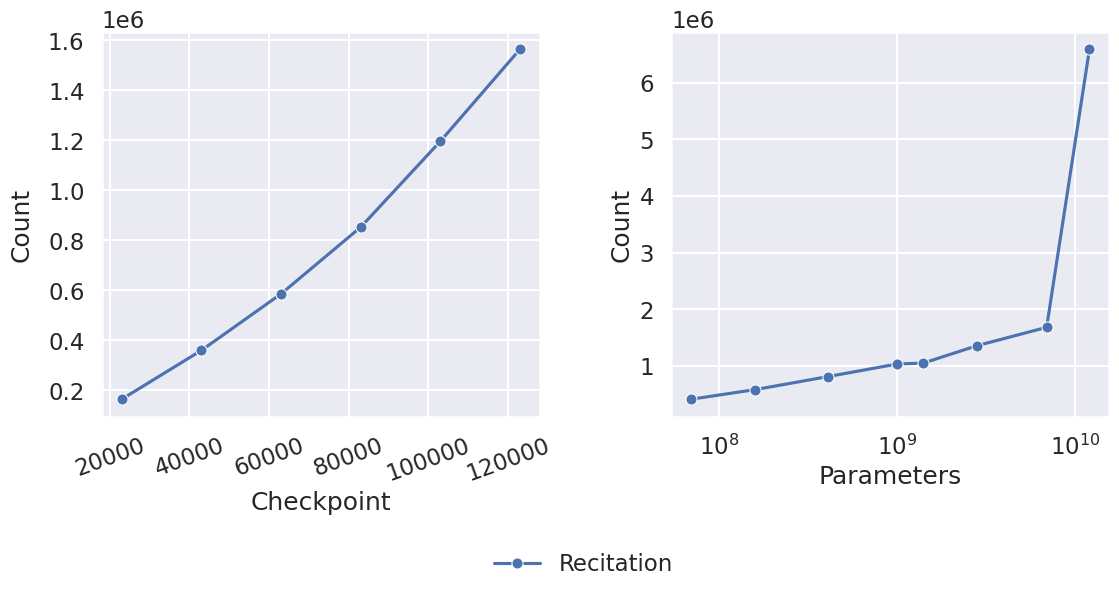

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# set figure 1
# first figure is a line plot of the counts of each category for across intermediate checkpoints

sns.lineplot(ax=axes[0], data=intermediate_checkpoint_counts_frame, dashes=False, markers=True, markersize=8)

# rotate x axis labels
axes[0].tick_params(axis='x', rotation=20)

# Add y label for Count
axes[0].set_ylabel("Count", labelpad=label_title_padding)

# add padding for labels
fig.subplots_adjust(wspace=0.2)

# # make x axis log scale
# axes[0].set_xscale("log")

# # have a common legend for both plots centered below the figure. No legend box
axes[0].legend(loc='upper center', bbox_to_anchor=(1.1, -0.3), ncol=4, frameon=False)

# have three equally spaces ticks on the x axis
# checkpoints = intermediate_checkpoint_counts_frame.index
# min_checkpoint = int(checkpoints[0])
# mid_checkpoint = int(checkpoints[len(checkpoints) // 2])
# max_checkpoint = int(checkpoints[-1])
# axes[0].set_xticks([min_checkpoint, mid_checkpoint, max_checkpoint])

# set figure 2
# the second figure is a line plot of the counts of each category across parameter count

sns.lineplot(ax=axes[1], data=final_checkpoint_counts_frame, dashes=False, markers=True, markersize=8)

# make x axis log scale
axes[1].set_xscale("log")

# Set x label to "Parameters"
axes[1].set_xlabel("Parameters")

# Add y label for Count
axes[1].set_ylabel("Count")

# remove legend
axes[1].legend().remove()

# add padding for labels
fig.subplots_adjust(wspace=0.30)

fig.savefig(f"categories_across_time+scale_recitation={RECITATION_THRESHOLD}.png", dpi=300, bbox_inches="tight")



### Figure: Prevalence and Percents of Memories by Taxonomy Across Param Count

 12%|█▎        | 1/8 [00:00<00:01,  6.77it/s]

{'Recitation': 1.0}
{'Recitation': 1.0}


 38%|███▊      | 3/8 [00:00<00:01,  4.31it/s]

{'Recitation': 1.0}


 50%|█████     | 4/8 [00:01<00:01,  3.36it/s]

{'Recitation': 1.0}


 62%|██████▎   | 5/8 [00:01<00:00,  3.06it/s]

{'Recitation': 1.0}


 75%|███████▌  | 6/8 [00:01<00:00,  2.57it/s]

{'Recitation': 1.0}


 88%|████████▊ | 7/8 [00:02<00:00,  2.16it/s]

{'Recitation': 1.0}
{'Recitation': 1.0}


100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


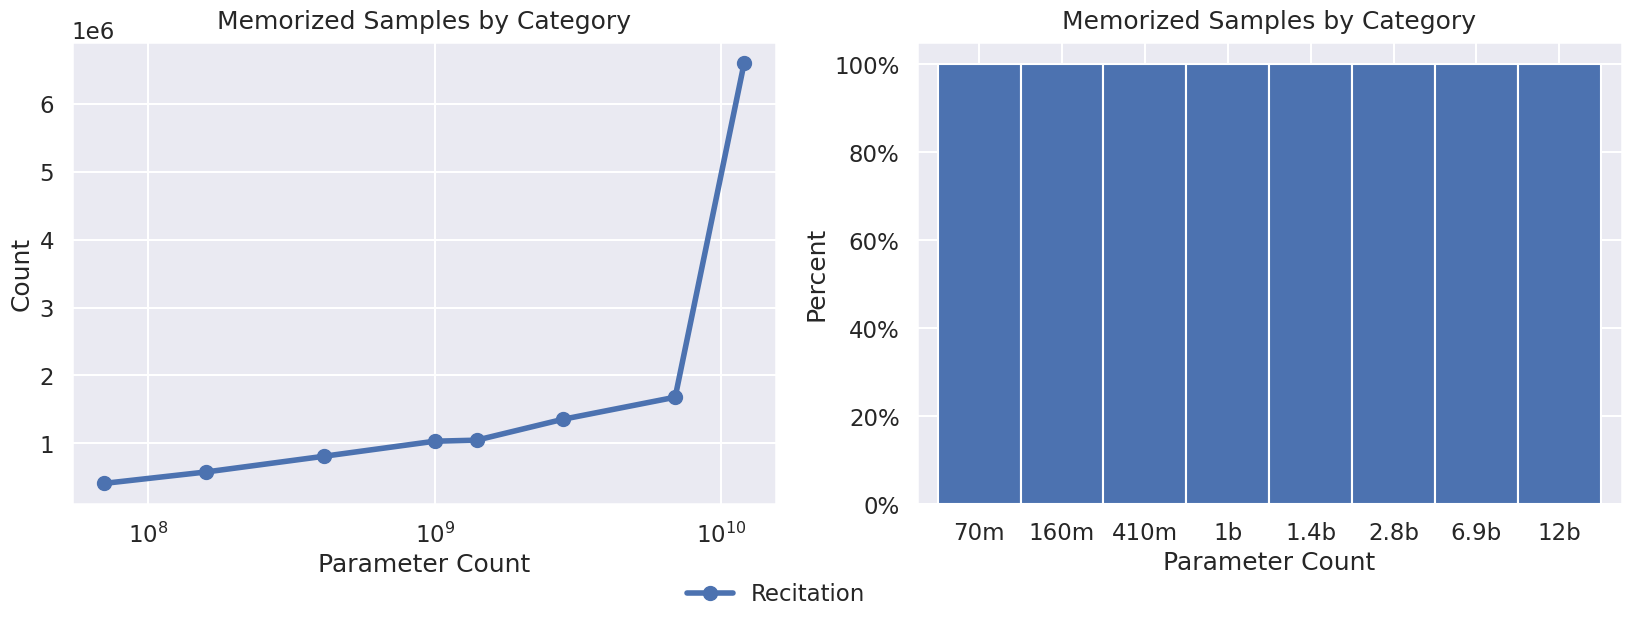

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

counts_frame = combined_dataframe.value_counts(["Param Count", "category"]).unstack().reindex(split_to_param_count.values())
counts_frame.plot.line(
    ax=axes[0],
    rot=0,
    ylabel="Count",
    marker="o",
    markersize=10,
    linewidth=4,
)

# log x axis
axes[0].set_xscale("log")

axes[0].set_title("Memorized Samples by Category", pad=label_title_padding)

# right plot is the each category across model size
all_percents = []
for param_count in tqdm(split_to_param_count.values()):
    model_examples = combined_dataframe[combined_dataframe["Param Count"] == param_count]
    model_percents = model_examples.value_counts("category", normalize=True).to_dict()
    print(model_percents)
    for category in model_percents:
        all_percents.append({
            "Model": model_examples["Model"].unique()[0],
            "Param Count": param_count,
            "category": category,
            "percent": model_percents[category],
        })

# create a normalized bar plot stacked by category with a seperate bar for each Model
# have no space between bars
percents_frame = pd.DataFrame(all_percents).pivot(index="Model", columns="category", values="percent").reindex(split_to_param_count.keys())
percents_frame.plot.bar(
    stacked=True,
    ax=axes[1],
    rot=0,
    width=1,
    ylabel="Percent",
)

axes[1].set_title("Memorized Samples by Category", pad=label_title_padding)
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}%".format(int(x * 100))))

# remove right legend
axes[1].get_legend().remove()

# have a common legend for both plots centered below the figure. No legend box
axes[0].legend(loc='upper center', bbox_to_anchor=(1, -0.125), ncol=4, frameon=False)

# set x label for both plots as "Parameter Count"
for ax in axes:
    ax.set_xlabel("Parameter Count")

# save figure_categories_count_pcercents.png
plt.savefig("figure_categories_count_percents.png", bbox_inches='tight')